In [69]:
import numpy as np
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import glob

In [4]:
def read_spectra(sobject_id):
    fits_files = [[],[],[],[]]
    for each_ccd in [1,2,3,4]:
        fits_files[each_ccd-1] = glob.glob('C:/Users/pravn/Dropbox/masters/python-code/galah-file-read-test/data/GALAH_DR3/spectra/SPECTRA/'+str(sobject_id)+str(each_ccd)+'.fits') #this is reading fits files from file and not downloading directly 

    spectrum = dict()
    for each_ccd in [1,2,3,4]: #GALAH uses indexing from 1 - 4
        if fits_files[each_ccd-1]!=[]: #just using zero indexing here 
            fits = pyfits.open(fits_files[each_ccd-1][0]) 
            
            # Extension 0: Reduced spectrum
            # Extension 1: Relative error spectrum
            # Extension 4: Normalised spectrum, NB: cut for CCD4

            # Extract wavelength grid for the reduced spectrum
            start_wavelength = fits[0].header["CRVAL1"]
            dispersion       = fits[0].header["CDELT1"]
            nr_pixels        = fits[0].header["NAXIS1"]
            reference_pixel  = fits[0].header["CRPIX1"]

            if reference_pixel == 0:
                reference_pixel = 1
            spectrum['wave_red_'+str(each_ccd)] = ((np.arange(0,nr_pixels)--reference_pixel+1)*dispersion+start_wavelength) #this is the reduced spectrum 

            # Extract wavelength grid for the normalised spectrum
            start_wavelength = fits[4].header["CRVAL1"]
            dispersion       = fits[4].header["CDELT1"]
            nr_pixels        = fits[4].header["NAXIS1"]
            reference_pixel  = fits[4].header["CRPIX1"]

            if reference_pixel == 0:
                reference_pixel=1
            spectrum['wave_norm_'+str(each_ccd)] = ((np.arange(0,nr_pixels)--reference_pixel+1)*dispersion+start_wavelength) #this is the normalised spectrum 

            # need to confirm how this is calculated 
            spectrum['sob_red_'+str(each_ccd)]  = np.array(fits[0].data)
            spectrum['uob_red_'+str(each_ccd)]  = np.array(fits[0].data * fits[1].data)

            # need to confirm how this is calculated 
            spectrum['sob_norm_'+str(each_ccd)] = np.array(fits[4].data)
            if each_ccd != 4:
                spectrum['uob_norm_'+str(each_ccd)] = np.array(fits[4].data * fits[1].data)
            else:
                # for normalised error of CCD4, only used appropriate parts of error spectrum
                spectrum['uob_norm_4'] = np.array(fits[4].data * (fits[1].data)[-len(spectrum['sob_norm_4']):])

            fits.close()
        else:
            spectrum['wave_red_'+str(each_ccd)] = []
            spectrum['wave_norm_'+str(each_ccd)] = []
            spectrum['sob_red_'+str(each_ccd)] = []
            spectrum['sob_norm_'+str(each_ccd)] = []
            spectrum['uob_red_'+str(each_ccd)] = []
            spectrum['uob_norm_'+str(each_ccd)] = []
    
    spectrum['wave_red'] = np.concatenate(([spectrum['wave_red_'+str(each_ccd)] for each_ccd in [1,2,3,4]]))
    spectrum['wave_norm'] = np.concatenate(([spectrum['wave_norm_'+str(each_ccd)] for each_ccd in [1,2,3,4]]))
    spectrum['sob_red'] = np.concatenate(([spectrum['sob_red_'+str(each_ccd)] for each_ccd in [1,2,3,4]]))
    spectrum['sob_norm'] = np.concatenate(([spectrum['sob_norm_'+str(each_ccd)] for each_ccd in [1,2,3,4]]))
    spectrum['uob_red'] = np.concatenate(([spectrum['uob_red_'+str(each_ccd)] for each_ccd in [1,2,3,4]]))
    spectrum['uob_norm'] = np.concatenate(([spectrum['uob_norm_'+str(each_ccd)] for each_ccd in [1,2,3,4]]))

    return spectrum 

In [5]:
def plot_spectra(sobject_id, normalised=True):
    
    f, ccds = plt.subplots(4,1,figsize=(11.69, 8.27))
    kwargs_sob = dict(c = 'k', lw=0.5, label='Flux', rasterized=True)
    kwargs_error_spectrum = dict(color = 'grey', label='Flux error', rasterized=True)

    for each_ccd in [1,2,3,4]:
        ax=ccds[each_ccd-1]
        
        if normalised:
            red_norm = 'norm'
        else:
            red_norm = 'red'
            
        # Plot the uncertainty as grey background
        ax.fill_between(
            spectrum['wave_'+red_norm+'_'+str(each_ccd)],
            spectrum['sob_'+red_norm+'_'+str(each_ccd)] - spectrum['uob_'+red_norm+'_'+str(each_ccd)],
            spectrum['sob_'+red_norm+'_'+str(each_ccd)] + spectrum['uob_'+red_norm+'_'+str(each_ccd)],
            **kwargs_error_spectrum
            )
        
        # Overplot observed spectrum a bit thicker
        ax.plot(
            spectrum['wave_'+red_norm+'_'+str(each_ccd)],
            spectrum['sob_'+red_norm+'_'+str(each_ccd)],
            **kwargs_sob
            )
        
        if normalised:
            ax.set_ylabel('Flux [norm.]')
            ax.set_ylim(-0.1,1.3)
        else:
            ax.set_ylabel('Counts')
            ax.set_ylim(0,1.1*np.percentile(spectrum['sob_red_'+str(each_ccd)],q=95))
        if each_ccd == 1:
            ax.set_title(str(sobject_id))
            ax.set_xlim(4710,4905)
        if each_ccd == 2:
            ax.set_xlim(5645,5877.5)
        if each_ccd == 3:
            ax.set_xlim(6472.5,6740)
        if each_ccd == 4:
            ax.set_xlim(7580,7890)
            ax.set_xlabel('Wavelength [Å]')
        if each_ccd == 4:
            ax.legend(loc='lower left')             
    plt.tight_layout()
    
    plt.show()
    plt.close()
    
    return f

In [70]:
spectrum = read_spectra(170418003701205) #test the read method by reading a previously downloaded GALAH fits file 

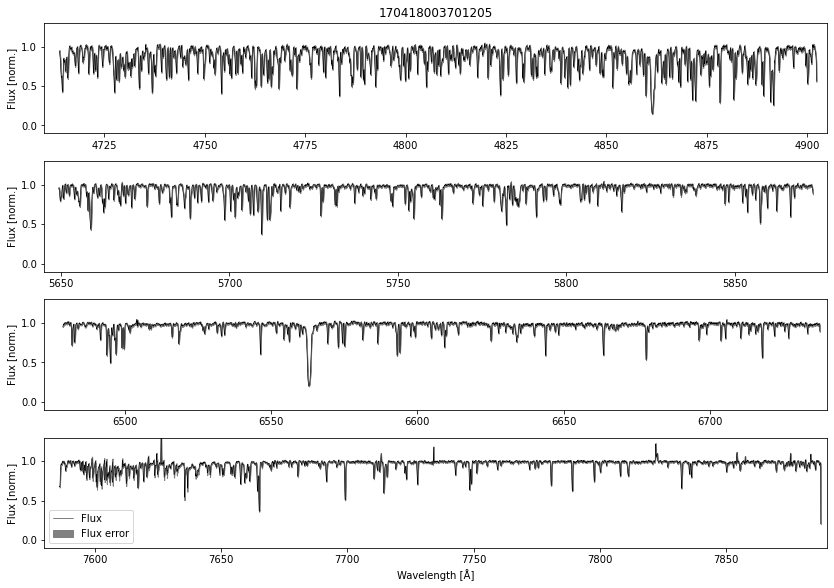

In [71]:
f = plot_spectra(170418003701205, normalised=True) # test the plotting method 

In [78]:
# making the plots look good 
import seaborn as sns 
plt.rcParams["figure.figsize"] = [16,9]
sns.set_style('darkgrid')

# loading spectres for a resampling test https://spectres.readthedocs.io/en/latest/ 
from spectres import spectres
from matplotlib import gridspec

In [100]:
GRID_SIZE = 0.1
LOWER_LAMBDA = 4710
UPPER_LAMBDA = 4905

In [101]:
# specify the grid of wavelengths onto which you wish to sample
# testing CCD1 _1 (see Sven's functions above)

regrid = np.arange(LOWER_LAMBDA, UPPER_LAMBDA, GRID_SIZE) 

In [102]:
# call the spectres function to resample the input spectrum or spectra to the new wavelength grid

spec_resample, spec_errs_resample = spectres(regrid,  spectrum['wave_norm_1'], spectrum['sob_norm_1'], spec_errs=spectrum['sob_norm_1'] - spectrum['uob_norm_1']) 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 



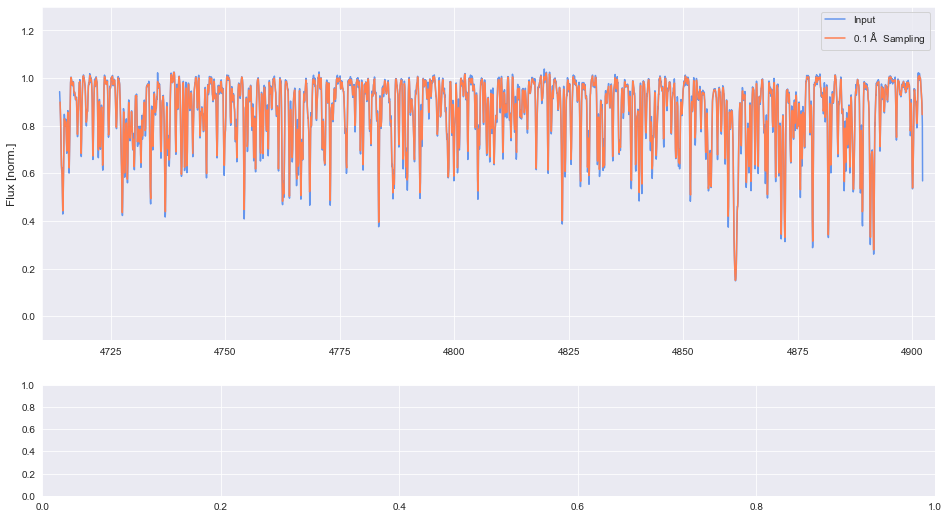

In [103]:
f, (ax1, ax2) = plt.subplots(2, figsize=(16,9))
gs = gridspec.GridSpec(2, 1, height_ratios=[3,1])

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.plot(spectrum['wave_norm_1'], spectrum['sob_norm_1'], color="cornflowerblue", lw=1.5, label="Input")
ax1.plot(regrid, spec_resample, color="coral", lw=1.5, label=str(GRID_SIZE)+" $\mathrm{\AA}\ $ Sampling")


#ax2.plot(spectrum[:,0], spectrum[:,2]*10**19, color="cornflowerblue", lw=1.5)
#ax2.plot(regrid, spec_errs_resample*10**19, color="coral", lw=1.5)

ax1.set_ylabel("Flux [norm.]", size=12)
#ax2.set_ylabel("Flux Error", size=18)

#ax2.set_xlabel("Wavelength ($\mathrm{\AA}$)", size=18)

ax1.set_xlim(LOWER_LAMBDA, UPPER_LAMBDA)
ax1.set_ylim(-0.1,1.3) # turn this into an input 
#ax2.set_xlim(6800, 9000)
#ax2.set_ylim(0, 0.08)
ax1.legend()

plt.show()